In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

2024-05-31 07:13:02.185717: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 07:13:02.219890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 07:13:02.219909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 07:13:02.220814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 07:13:02.226781: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


## Example Pinball loss / Quantile loss

In [3]:
tau=0.1
y_hat=3
y=np.linspace(y_hat-10,y_hat+10,100)

# Calculate loss
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat
loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [4]:
loss=(1-tau)*(np.abs(y-y_hat))
y_larger=y>y_hat

loss[y_larger]=tau*(np.abs(y[y_larger]-y_hat))

In [5]:
tau=0.1
y_hat=3
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]

def plot_function(tau):
    
    loss=(1-tau)*(np.abs(u))
    y_larger=u<0
    loss[y_larger]=tau*(np.abs(u[y_larger]))

    plt.plot(u,loss)
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.grid()
    plt.xticks(u_ticks)
    plt.xlim([-10,10])
    plt.ylim([-1,8])
    plt.legend([r'$\mathcal{L}(y_{\tau},y)$',r'$y_{\tau}$'])
    plt.xlabel(r"$u=y_{\tau}-y$")
    plt.ylabel(r'$\mathcal{L}$')
    plt.title(r'Example of the Quantile loss / Pinball loss function')
    plt.show()
    
interact(plot_function, tau = widgets.FloatSlider(value=0.1,
                                               min=0.0,
                                               max=1.0,
                                               step=0.01))

interactive(children=(FloatSlider(value=0.1, description='tau', max=1.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_function(tau)>

## Plot for report

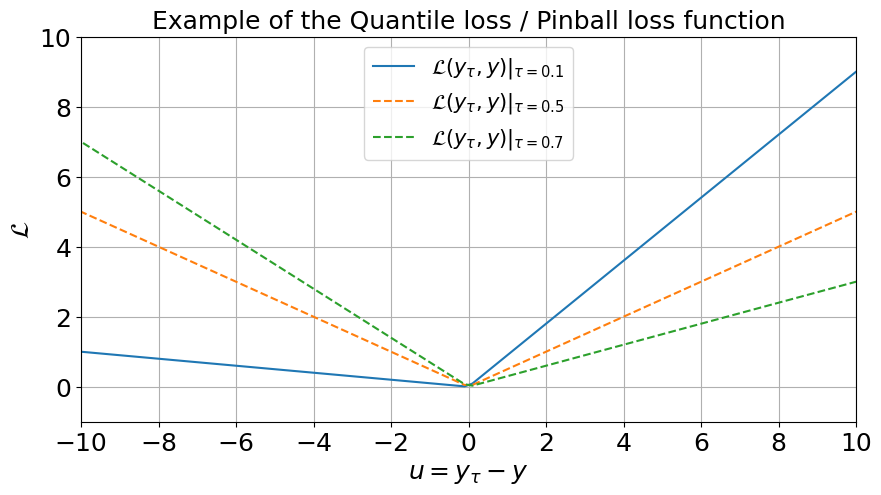

In [6]:
tau=0.1
u=np.linspace(-100,100,1000)
u_ints=np.unique(np.ceil(u))
u_ticks=u_ints[np.nonzero((u_ints%2)==0)]    

loss=(1-tau)*(np.abs(u))
y_larger=u<0
loss[y_larger]=tau*(np.abs(u[y_larger]))

tau_2=0.5
loss_2=(1-tau_2)*(np.abs(u))
loss_2[y_larger]=tau_2*(np.abs(u[y_larger]))

tau_3=0.7
loss_3=(1-tau_3)*(np.abs(u))
loss_3[y_larger]=tau_3*(np.abs(u[y_larger]))

fontsize=18

plt.plot(u,loss)
plt.plot(u,loss_2,'--')
plt.plot(u,loss_3,'--')
plt.rcParams["figure.figsize"] = [10, 5]
plt.grid()
plt.xticks(u_ticks,fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim([-10,10])
plt.ylim([-1,10])
plt.legend([r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.1}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.5}$',r'$\mathcal{L}(y_{\tau},y)|_{\tau =0.7}$'],fontsize=fontsize-3)
plt.xlabel(r"$u=y_{\tau}-y$",fontsize=fontsize)
plt.ylabel(r'$\mathcal{L}$',fontsize=fontsize)
plt.title(r'Example of the Quantile loss / Pinball loss function',fontsize=fontsize)
plt.show()

## Example Quantile Regression Neural Networks (QRNN)

In [41]:
def draw_sample_sin(n_samps, sigma):
    x=np.random.uniform(low=0,high=2*np.pi,size=n_samps)
    noise=np.random.normal(loc=0,scale=sigma,size=n_samps)
    y=np.sin(x)+np.cos(x+noise )+noise 
    return x,y

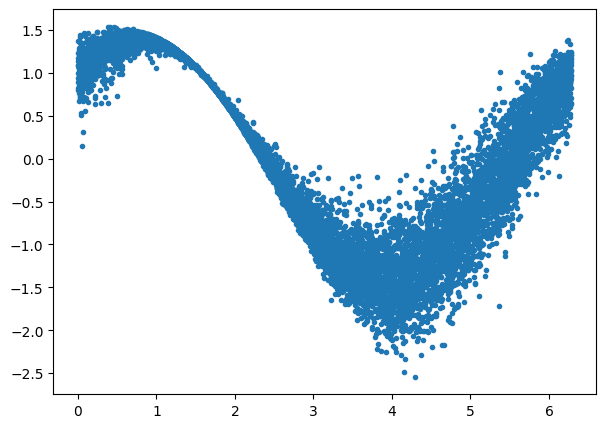

In [49]:
x,y = draw_sample_sin(10000,0.2)
plt.plot(x,y,'.')

In [50]:
x=np.array([x]).T
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.05)


import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train)), int(len(X_train)*val_size)))
train_indices=[i for i in range(len(X_train)) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500


In [51]:
nepochs=200
quantiles=np.array([0.025,0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95,0.975])
quantiles_01=np.array([0,0.025,0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95,0.975,1])

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(1,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*1) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train,y_train, 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


/home/edgelab/.local/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Batch number: 100%|██████████| 19/19 [00:00<00:00, 541.54it/s]

Training loss [12.34192] Validation loss [5.7509866]
----New best validation loss---- [5.7509866]
Epoch 2



Batch number: 100%|██████████| 19/19 [00:00<00:00, 629.56it/s]

Training loss [4.2083936] Validation loss [3.47947]
----New best validation loss---- [3.47947]
Epoch 3



Batch number: 100%|██████████| 19/19 [00:00<00:00, 627.66it/s]

Training loss [3.1541677] Validation loss [2.827813]
----New best validation loss---- [2.827813]
Epoch 4



Batch number: 100%|██████████| 19/19 [00:00<00:00, 622.53it/s]

Training loss [2.745075] Validation loss [2.6285105]
----New best validation loss---- [2.6285105]
Epoch 5



Batch number: 100%|██████████| 19/19 [00:00<00:00, 635.64it/s]

Training loss [2.5756075] Validation loss [2.5234573]
----New best validation loss---- [2.5234573]
Epoch 6



Batch number: 100%|██████████| 19/19 [00:00<00:00, 630.20it/s]

Training loss [2.4884045] Validation loss [2.4584882]
----New best validation loss---- [2.4584882]
Epoch 7



Batch number: 100%|██████████| 19/19 [00:00<00:00, 595.19it/s]

Training loss [2.4367392] Validation loss [2.4222639]
----New best validation loss---- [2.4222639]
Epoch 8



Batch number: 100%|██████████| 19/19 [00:00<00:00, 567.97it/s]

Training loss [2.3931234] Validation loss [2.375503]
----New best validation loss---- [2.375503]
Epoch 9



Batch number: 100%|██████████| 19/19 [00:00<00:00, 568.03it/s]

Training loss [2.354693] Validation loss [2.3285017]
----New best validation loss---- [2.3285017]
Epoch 10



Batch number: 100%|██████████| 19/19 [00:00<00:00, 563.20it/s]

Training loss [2.3157027] Validation loss [2.2822874]
----New best validation loss---- [2.2822874]
Epoch 11



Batch number: 100%|██████████| 19/19 [00:00<00:00, 561.67it/s]


Training loss [2.273716] Validation loss [2.258974]
----New best validation loss---- [2.258974]
Epoch 12


Batch number: 100%|██████████| 19/19 [00:00<00:00, 569.43it/s]

Training loss [2.2290485] Validation loss [2.2060084]
----New best validation loss---- [2.2060084]
Epoch 13



Batch number: 100%|██████████| 19/19 [00:00<00:00, 548.36it/s]

Training loss [2.1903005] Validation loss [2.1569057]


----New best validation loss---- [2.1569057]
Epoch 14


Batch number: 100%|██████████| 19/19 [00:00<00:00, 559.37it/s]

Training loss [2.1448936] Validation loss [2.1081753]


----New best validation loss---- [2.1081753]
Epoch 15


Batch number: 100%|██████████| 19/19 [00:00<00:00, 557.04it/s]

Training loss [2.090526] Validation loss [2.0602343]


----New best validation loss---- [2.0602343]
Epoch 16


Batch number: 100%|██████████| 19/19 [00:00<00:00, 553.40it/s]

Training loss [2.0348523] Validation loss [2.0008907]
----New best validation loss---- [2.0008907]
Epoch 17



Batch number: 100%|██████████| 19/19 [00:00<00:00, 560.09it/s]

Training loss [1.9837176] Validation loss [1.9559927]
----New best validation loss---- [1.9559927]
Epoch 18



Batch number: 100%|██████████| 19/19 [00:00<00:00, 551.21it/s]

Training loss [1.9375454] Validation loss [1.8978851]
----New best validation loss---- [1.8978851]
Epoch 19



Batch number: 100%|██████████| 19/19 [00:00<00:00, 565.35it/s]

Training loss [1.8933018] Validation loss [1.8528084]
----New best validation loss---- [1.8528084]
Epoch 20



Batch number: 100%|██████████| 19/19 [00:00<00:00, 559.59it/s]

Training loss [1.8444403] Validation loss [1.8130717]


----New best validation loss---- [1.8130717]
Epoch 21


Batch number: 100%|██████████| 19/19 [00:00<00:00, 560.33it/s]

Training loss [1.8012593] Validation loss [1.7693208]
----New best validation loss---- [1.7693208]
Epoch 22



Batch number: 100%|██████████| 19/19 [00:00<00:00, 579.77it/s]

Training loss [1.7585763] Validation loss [1.7248821]
----New best validation loss---- [1.7248821]
Epoch 23



Batch number: 100%|██████████| 19/19 [00:00<00:00, 554.60it/s]


Training loss [1.7146664] Validation loss [1.6759605]
----New best validation loss---- [1.6759605]
Epoch 24


Batch number: 100%|██████████| 19/19 [00:00<00:00, 582.67it/s]


Training loss [1.6724088] Validation loss [1.6423055]
----New best validation loss---- [1.6423055]
Epoch 25


Batch number: 100%|██████████| 19/19 [00:00<00:00, 546.01it/s]


Training loss [1.6305267] Validation loss [1.5879489]
----New best validation loss---- [1.5879489]
Epoch 26


Batch number: 100%|██████████| 19/19 [00:00<00:00, 540.75it/s]

Training loss [1.5808415] Validation loss [1.5625526]
----New best validation loss---- [1.5625526]
Epoch 27



Batch number: 100%|██████████| 19/19 [00:00<00:00, 567.46it/s]

Training loss [1.5365989] Validation loss [1.5046014]
----New best validation loss---- [1.5046014]
Epoch 28



Batch number: 100%|██████████| 19/19 [00:00<00:00, 550.84it/s]

Training loss [1.4976901] Validation loss [1.4764295]
----New best validation loss---- [1.4764295]
Epoch 29



Batch number: 100%|██████████| 19/19 [00:00<00:00, 568.61it/s]

Training loss [1.4576877] Validation loss [1.423955]


----New best validation loss---- [1.423955]
Epoch 30


Batch number: 100%|██████████| 19/19 [00:00<00:00, 545.09it/s]

Training loss [1.4175402] Validation loss [1.3951466]


----New best validation loss---- [1.3951466]
Epoch 31


Batch number: 100%|██████████| 19/19 [00:00<00:00, 568.78it/s]


Training loss [1.384784] Validation loss [1.363371]
----New best validation loss---- [1.363371]
Epoch 32


Batch number: 100%|██████████| 19/19 [00:00<00:00, 477.48it/s]

Training loss [1.3464321] Validation loss [1.334072]
----New best validation loss---- [1.334072]
Epoch 33



Batch number: 100%|██████████| 19/19 [00:00<00:00, 564.89it/s]

Training loss [1.3126018] Validation loss [1.3198272]
----New best validation loss---- [1.3198272]
Epoch 34



Batch number: 100%|██████████| 19/19 [00:00<00:00, 582.32it/s]


Training loss [1.2830178] Validation loss [1.2892555]
----New best validation loss---- [1.2892555]
Epoch 35


Batch number: 100%|██████████| 19/19 [00:00<00:00, 580.44it/s]

Training loss [1.2535974] Validation loss [1.2459363]


----New best validation loss---- [1.2459363]
Epoch 36


Batch number: 100%|██████████| 19/19 [00:00<00:00, 581.97it/s]

Training loss [1.2247578] Validation loss [1.2225254]
----New best validation loss---- [1.2225254]
Epoch 37



Batch number: 100%|██████████| 19/19 [00:00<00:00, 589.91it/s]

Training loss [1.1960682] Validation loss [1.1954179]
----New best validation loss---- [1.1954179]
Epoch 38



Batch number: 100%|██████████| 19/19 [00:00<00:00, 578.77it/s]

Training loss [1.1750803] Validation loss [1.184445]
----New best validation loss---- [1.184445]
Epoch 39



Batch number: 100%|██████████| 19/19 [00:00<00:00, 578.96it/s]

Training loss [1.1488233] Validation loss [1.1402965]
----New best validation loss---- [1.1402965]
Epoch 40



Batch number: 100%|██████████| 19/19 [00:00<00:00, 579.41it/s]

Training loss [1.1261909] Validation loss [1.1439612]
Epoch 41



Batch number: 100%|██████████| 19/19 [00:00<00:00, 557.33it/s]

Training loss [1.0991462] Validation loss [1.1168187]
----New best validation loss---- [1.1168187]
Epoch 42



Batch number: 100%|██████████| 19/19 [00:00<00:00, 576.65it/s]

Training loss [1.0828855] Validation loss [1.0928054]
----New best validation loss---- [1.0928054]
Epoch 43



Batch number: 100%|██████████| 19/19 [00:00<00:00, 574.89it/s]

Training loss [1.0621424] Validation loss [1.1072657]
Epoch 44



Batch number: 100%|██████████| 19/19 [00:00<00:00, 564.31it/s]

Training loss [1.0474273] Validation loss [1.053795]
----New best validation loss---- [1.053795]
Epoch 45



Batch number: 100%|██████████| 19/19 [00:00<00:00, 572.17it/s]

Training loss [1.0261633] Validation loss [1.0430766]
----New best validation loss---- [1.0430766]
Epoch 46



Batch number: 100%|██████████| 19/19 [00:00<00:00, 578.38it/s]

Training loss [1.0118295] Validation loss [1.0338509]
----New best validation loss---- [1.0338509]
Epoch 47



Batch number: 100%|██████████| 19/19 [00:00<00:00, 570.62it/s]

Training loss [0.99393266] Validation loss [1.0241734]
----New best validation loss---- [1.0241734]
Epoch 48



Batch number: 100%|██████████| 19/19 [00:00<00:00, 563.34it/s]

Training loss [0.97767204] Validation loss [1.0059615]
----New best validation loss---- [1.0059615]
Epoch 49



Batch number: 100%|██████████| 19/19 [00:00<00:00, 573.91it/s]

Training loss [0.9679613] Validation loss [0.96243554]
----New best validation loss---- [0.96243554]
Epoch 50



Batch number: 100%|██████████| 19/19 [00:00<00:00, 577.42it/s]

Training loss [0.94572496] Validation loss [0.95785075]
----New best validation loss---- [0.95785075]
Epoch 51



Batch number: 100%|██████████| 19/19 [00:00<00:00, 575.23it/s]

Training loss [0.9261076] Validation loss [0.95126677]
----New best validation loss---- [0.95126677]
Epoch 52



Batch number: 100%|██████████| 19/19 [00:00<00:00, 577.46it/s]

Training loss [0.8995623] Validation loss [0.91143167]
----New best validation loss---- [0.91143167]
Epoch 53



Batch number: 100%|██████████| 19/19 [00:00<00:00, 569.38it/s]

Training loss [0.88147926] Validation loss [0.9125482]
Epoch 54



Batch number: 100%|██████████| 19/19 [00:00<00:00, 561.24it/s]

Training loss [0.86536974] Validation loss [0.8810463]
----New best validation loss---- [0.8810463]
Epoch 55



Batch number: 100%|██████████| 19/19 [00:00<00:00, 576.47it/s]

Training loss [0.85458374] Validation loss [0.8871688]
Epoch 56



Batch number: 100%|██████████| 19/19 [00:00<00:00, 562.51it/s]

Training loss [0.8505572] Validation loss [0.86881757]
----New best validation loss---- [0.86881757]
Epoch 57



Batch number: 100%|██████████| 19/19 [00:00<00:00, 571.34it/s]

Training loss [0.8419865] Validation loss [0.87591535]
Epoch 58



Batch number: 100%|██████████| 19/19 [00:00<00:00, 548.80it/s]

Training loss [0.84260637] Validation loss [0.8881574]
Epoch 59



Batch number: 100%|██████████| 19/19 [00:00<00:00, 568.75it/s]

Training loss [0.83710104] Validation loss [0.8682488]
----New best validation loss---- [0.8682488]
Epoch 60



Batch number: 100%|██████████| 19/19 [00:00<00:00, 571.88it/s]

Training loss [0.8408734] Validation loss [0.8551273]
----New best validation loss---- [0.8551273]
Epoch 61



Batch number: 100%|██████████| 19/19 [00:00<00:00, 584.64it/s]

Training loss [0.83063066] Validation loss [0.83491915]
----New best validation loss---- [0.83491915]
Epoch 62



Batch number: 100%|██████████| 19/19 [00:00<00:00, 570.31it/s]

Training loss [0.82894856] Validation loss [0.87147236]
Epoch 63



Batch number: 100%|██████████| 19/19 [00:00<00:00, 560.56it/s]

Training loss [0.8222957] Validation loss [0.8566975]
Epoch 64



Batch number: 100%|██████████| 19/19 [00:00<00:00, 563.60it/s]

Training loss [0.8282211] Validation loss [0.83673924]
Epoch 65



Batch number: 100%|██████████| 19/19 [00:00<00:00, 558.61it/s]

Training loss [0.81315136] Validation loss [0.82611334]
----New best validation loss---- [0.82611334]
Epoch 66



Batch number: 100%|██████████| 19/19 [00:00<00:00, 591.40it/s]

Training loss [0.80753773] Validation loss [0.8510726]
Epoch 67



Batch number: 100%|██████████| 19/19 [00:00<00:00, 554.39it/s]

Training loss [0.8103508] Validation loss [0.8592655]
Epoch 68



Batch number: 100%|██████████| 19/19 [00:00<00:00, 566.56it/s]

Training loss [0.80779475] Validation loss [0.84723455]
Epoch 69



Batch number: 100%|██████████| 19/19 [00:00<00:00, 570.87it/s]

Training loss [0.80600595] Validation loss [0.8476435]
Epoch 70



Batch number: 100%|██████████| 19/19 [00:00<00:00, 564.04it/s]

Training loss [0.80380505] Validation loss [0.84809756]
Epoch 71



Batch number: 100%|██████████| 19/19 [00:00<00:00, 567.48it/s]

Training loss [0.80035245] Validation loss [0.8460379]
Epoch 72



Batch number: 100%|██████████| 19/19 [00:00<00:00, 564.51it/s]

Training loss [0.7950818] Validation loss [0.83119404]
Epoch 73



Batch number: 100%|██████████| 19/19 [00:00<00:00, 571.12it/s]

Training loss [0.7939597] Validation loss [0.8231365]
----New best validation loss---- [0.8231365]
Epoch 74



Batch number: 100%|██████████| 19/19 [00:00<00:00, 578.71it/s]

Training loss [0.80212337] Validation loss [0.8254765]
Epoch 75



Batch number: 100%|██████████| 19/19 [00:00<00:00, 558.53it/s]

Training loss [0.7985226] Validation loss [0.8325203]
Epoch 76



Batch number: 100%|██████████| 19/19 [00:00<00:00, 570.27it/s]

Training loss [0.7934932] Validation loss [0.81490695]
----New best validation loss---- [0.81490695]
Epoch 77



Batch number: 100%|██████████| 19/19 [00:00<00:00, 581.83it/s]

Training loss [0.79868484] Validation loss [0.8313805]
Epoch 78



Batch number: 100%|██████████| 19/19 [00:00<00:00, 569.80it/s]

Training loss [0.79923874] Validation loss [0.81108576]
----New best validation loss---- [0.81108576]
Epoch 79



Batch number: 100%|██████████| 19/19 [00:00<00:00, 571.21it/s]

Training loss [0.7909169] Validation loss [0.82143605]
Epoch 80



Batch number: 100%|██████████| 19/19 [00:00<00:00, 572.12it/s]

Training loss [0.79338497] Validation loss [0.8061858]
----New best validation loss---- [0.8061858]
Epoch 81



Batch number: 100%|██████████| 19/19 [00:00<00:00, 582.41it/s]

Training loss [0.7926607] Validation loss [0.8150155]
Epoch 82



Batch number: 100%|██████████| 19/19 [00:00<00:00, 572.51it/s]

Training loss [0.7899494] Validation loss [0.8144882]
Epoch 83



Batch number: 100%|██████████| 19/19 [00:00<00:00, 566.12it/s]

Training loss [0.7918478] Validation loss [0.80316186]
----New best validation loss---- [0.80316186]
Epoch 84



Batch number: 100%|██████████| 19/19 [00:00<00:00, 580.36it/s]

Training loss [0.78959453] Validation loss [0.8165048]
Epoch 85



Batch number: 100%|██████████| 19/19 [00:00<00:00, 562.12it/s]

Training loss [0.7895101] Validation loss [0.82210803]
Epoch 86



Batch number: 100%|██████████| 19/19 [00:00<00:00, 562.14it/s]

Training loss [0.78792566] Validation loss [0.79868686]
----New best validation loss---- [0.79868686]
Epoch 87



Batch number: 100%|██████████| 19/19 [00:00<00:00, 589.99it/s]

Training loss [0.7874707] Validation loss [0.8165118]
Epoch 88



Batch number: 100%|██████████| 19/19 [00:00<00:00, 573.88it/s]

Training loss [0.79359883] Validation loss [0.796002]
----New best validation loss---- [0.796002]
Epoch 89



Batch number: 100%|██████████| 19/19 [00:00<00:00, 596.48it/s]

Training loss [0.7927462] Validation loss [0.8044068]
Epoch 90



Batch number: 100%|██████████| 19/19 [00:00<00:00, 564.80it/s]

Training loss [0.7828811] Validation loss [0.8103162]
Epoch 91



Batch number: 100%|██████████| 19/19 [00:00<00:00, 584.34it/s]

Training loss [0.78419507] Validation loss [0.8154288]
Epoch 92



Batch number: 100%|██████████| 19/19 [00:00<00:00, 581.09it/s]

Training loss [0.78272104] Validation loss [0.7870862]
----New best validation loss---- [0.7870862]
Epoch 93



Batch number: 100%|██████████| 19/19 [00:00<00:00, 588.01it/s]

Training loss [0.78328866] Validation loss [0.78126585]
----New best validation loss---- [0.78126585]
Epoch 94



Batch number: 100%|██████████| 19/19 [00:00<00:00, 585.18it/s]

Training loss [0.7875036] Validation loss [0.7877565]
Epoch 95



Batch number: 100%|██████████| 19/19 [00:00<00:00, 569.64it/s]

Training loss [0.7810772] Validation loss [0.79713637]
Epoch 96



Batch number: 100%|██████████| 19/19 [00:00<00:00, 582.39it/s]

Training loss [0.7907809] Validation loss [0.8115072]
Epoch 97



Batch number: 100%|██████████| 19/19 [00:00<00:00, 566.54it/s]

Training loss [0.7823083] Validation loss [0.8031052]
Epoch 98



Batch number: 100%|██████████| 19/19 [00:00<00:00, 576.29it/s]

Training loss [0.77834123] Validation loss [0.7965026]
Epoch 99



Batch number: 100%|██████████| 19/19 [00:00<00:00, 553.48it/s]

Training loss [0.77962226] Validation loss [0.80178154]
Epoch 100



Batch number: 100%|██████████| 19/19 [00:00<00:00, 548.68it/s]

Training loss [0.7729759] Validation loss [0.78966725]
Epoch 101



Batch number: 100%|██████████| 19/19 [00:00<00:00, 581.97it/s]

Training loss [0.7836503] Validation loss [0.8014929]
Epoch 102



Batch number: 100%|██████████| 19/19 [00:00<00:00, 579.65it/s]

Training loss [0.78408504] Validation loss [0.7922147]
Epoch 103



Batch number: 100%|██████████| 19/19 [00:00<00:00, 589.92it/s]

Training loss [0.78200114] Validation loss [0.7882511]
Epoch 104



Batch number: 100%|██████████| 19/19 [00:00<00:00, 575.67it/s]

Training loss [0.77688956] Validation loss [0.8081162]
Epoch 105



Batch number: 100%|██████████| 19/19 [00:00<00:00, 587.33it/s]

Training loss [0.7876271] Validation loss [0.7980255]
Epoch 106



Batch number: 100%|██████████| 19/19 [00:00<00:00, 579.40it/s]

Training loss [0.78007644] Validation loss [0.8127485]
Epoch 107



Batch number: 100%|██████████| 19/19 [00:00<00:00, 563.33it/s]

Training loss [0.7749035] Validation loss [0.7952409]
Epoch 108



Batch number: 100%|██████████| 19/19 [00:00<00:00, 576.40it/s]

Training loss [0.7755341] Validation loss [0.7844368]
Epoch 109



Batch number: 100%|██████████| 19/19 [00:00<00:00, 584.42it/s]

Training loss [0.7790819] Validation loss [0.7980073]
Epoch 110



Batch number: 100%|██████████| 19/19 [00:00<00:00, 572.13it/s]

Training loss [0.77370346] Validation loss [0.81272703]
Epoch 111



Batch number: 100%|██████████| 19/19 [00:00<00:00, 580.45it/s]

Training loss [0.7773189] Validation loss [0.8059312]
Epoch 112



Batch number: 100%|██████████| 19/19 [00:00<00:00, 575.75it/s]

Training loss [0.77236927] Validation loss [0.8074075]
Epoch 113



Batch number: 100%|██████████| 19/19 [00:00<00:00, 576.28it/s]

Training loss [0.7771109] Validation loss [0.78599966]
Epoch 114



Batch number: 100%|██████████| 19/19 [00:00<00:00, 580.71it/s]

Training loss [0.77066934] Validation loss [0.8092264]
Epoch 115



Batch number: 100%|██████████| 19/19 [00:00<00:00, 584.86it/s]

Training loss [0.7754209] Validation loss [0.7655611]
----New best validation loss---- [0.7655611]
Epoch 116



Batch number: 100%|██████████| 19/19 [00:00<00:00, 616.39it/s]

Training loss [0.77692616] Validation loss [0.8032757]
Epoch 117



Batch number: 100%|██████████| 19/19 [00:00<00:00, 572.20it/s]

Training loss [0.77299356] Validation loss [0.7892705]
Epoch 118



Batch number: 100%|██████████| 19/19 [00:00<00:00, 580.51it/s]

Training loss [0.77376145] Validation loss [0.7760426]
Epoch 119



Batch number: 100%|██████████| 19/19 [00:00<00:00, 571.83it/s]

Training loss [0.7737877] Validation loss [0.7961001]
Epoch 120



Batch number: 100%|██████████| 19/19 [00:00<00:00, 574.72it/s]

Training loss [0.7719959] Validation loss [0.782791]
Epoch 121



Batch number: 100%|██████████| 19/19 [00:00<00:00, 571.49it/s]

Training loss [0.7632574] Validation loss [0.7659584]
Epoch 122



Batch number: 100%|██████████| 19/19 [00:00<00:00, 569.27it/s]

Training loss [0.76661074] Validation loss [0.76081026]
----New best validation loss---- [0.76081026]
Epoch 123



Batch number: 100%|██████████| 19/19 [00:00<00:00, 611.45it/s]

Training loss [0.7632011] Validation loss [0.7887595]
Epoch 124



Batch number: 100%|██████████| 19/19 [00:00<00:00, 573.78it/s]

Training loss [0.7711447] Validation loss [0.774579]
Epoch 125



Batch number: 100%|██████████| 19/19 [00:00<00:00, 576.47it/s]

Training loss [0.7677742] Validation loss [0.79848284]
Epoch 126



Batch number: 100%|██████████| 19/19 [00:00<00:00, 570.23it/s]

Training loss [0.7694373] Validation loss [0.8126539]
Epoch 127



Batch number: 100%|██████████| 19/19 [00:00<00:00, 577.55it/s]

Training loss [0.7642973] Validation loss [0.78041244]
Epoch 128



Batch number: 100%|██████████| 19/19 [00:00<00:00, 568.69it/s]

Training loss [0.76701224] Validation loss [0.7897499]
Epoch 129



Batch number: 100%|██████████| 19/19 [00:00<00:00, 581.07it/s]

Training loss [0.75999975] Validation loss [0.7864396]
Epoch 130



Batch number: 100%|██████████| 19/19 [00:00<00:00, 574.44it/s]

Training loss [0.7657579] Validation loss [0.7846682]
Epoch 131



Batch number: 100%|██████████| 19/19 [00:00<00:00, 575.25it/s]

Training loss [0.76335055] Validation loss [0.79165757]
Epoch 132



Batch number: 100%|██████████| 19/19 [00:00<00:00, 585.72it/s]

Training loss [0.7637284] Validation loss [0.76837975]
Epoch 133



Batch number: 100%|██████████| 19/19 [00:00<00:00, 557.64it/s]

Training loss [0.7644832] Validation loss [0.8024784]
Epoch 134



Batch number: 100%|██████████| 19/19 [00:00<00:00, 580.02it/s]

Training loss [0.7607982] Validation loss [0.8017081]
Epoch 135



Batch number: 100%|██████████| 19/19 [00:00<00:00, 564.07it/s]

Training loss [0.76194125] Validation loss [0.7712746]
Epoch 136



Batch number: 100%|██████████| 19/19 [00:00<00:00, 563.37it/s]

Training loss [0.75884026] Validation loss [0.7815287]
Epoch 137



Batch number: 100%|██████████| 19/19 [00:00<00:00, 576.44it/s]

Training loss [0.7669427] Validation loss [0.7984028]
Epoch 138



Batch number: 100%|██████████| 19/19 [00:00<00:00, 570.47it/s]

Training loss [0.764566] Validation loss [0.78090215]
Epoch 139



Batch number: 100%|██████████| 19/19 [00:00<00:00, 571.41it/s]

Training loss [0.7544648] Validation loss [0.78613156]
Epoch 140



Batch number: 100%|██████████| 19/19 [00:00<00:00, 569.61it/s]

Training loss [0.762276] Validation loss [0.7682225]
Epoch 141



Batch number: 100%|██████████| 19/19 [00:00<00:00, 562.91it/s]

Training loss [0.75798374] Validation loss [0.8000821]
Epoch 142



Batch number: 100%|██████████| 19/19 [00:00<00:00, 574.27it/s]

Training loss [0.7633584] Validation loss [0.78125215]
Epoch 143



Batch number: 100%|██████████| 19/19 [00:00<00:00, 564.39it/s]

Training loss [0.75894666] Validation loss [0.7914352]
Epoch 144



Batch number: 100%|██████████| 19/19 [00:00<00:00, 573.64it/s]

Training loss [0.7597387] Validation loss [0.78062624]
Epoch 145



Batch number: 100%|██████████| 19/19 [00:00<00:00, 568.79it/s]

Training loss [0.75830626] Validation loss [0.7741713]
Epoch 146



Batch number: 100%|██████████| 19/19 [00:00<00:00, 580.25it/s]

Training loss [0.756107] Validation loss [0.7836324]
Epoch 147



Batch number: 100%|██████████| 19/19 [00:00<00:00, 580.64it/s]

Training loss [0.76445013] Validation loss [0.77739435]
Epoch 148



Batch number: 100%|██████████| 19/19 [00:00<00:00, 572.43it/s]

Training loss [0.75795233] Validation loss [0.76228684]
Epoch 149



Batch number: 100%|██████████| 19/19 [00:00<00:00, 579.85it/s]

Training loss [0.75700855] Validation loss [0.7826509]
Epoch 150



Batch number: 100%|██████████| 19/19 [00:00<00:00, 567.57it/s]

Training loss [0.756604] Validation loss [0.77571714]
Epoch 151



Batch number: 100%|██████████| 19/19 [00:00<00:00, 578.59it/s]

Training loss [0.7591874] Validation loss [0.7699659]
Epoch 152



Batch number: 100%|██████████| 19/19 [00:00<00:00, 565.59it/s]

Training loss [0.75508386] Validation loss [0.7887019]
Epoch 153



Batch number: 100%|██████████| 19/19 [00:00<00:00, 546.53it/s]

Training loss [0.7578439] Validation loss [0.76698405]
Epoch 154



Batch number: 100%|██████████| 19/19 [00:00<00:00, 567.28it/s]

Training loss [0.75457853] Validation loss [0.7867271]
Epoch 155



Batch number: 100%|██████████| 19/19 [00:00<00:00, 574.74it/s]

Training loss [0.7576722] Validation loss [0.76311016]
Epoch 156



Batch number: 100%|██████████| 19/19 [00:00<00:00, 573.67it/s]

Training loss [0.7462146] Validation loss [0.771578]
Epoch 157



Batch number: 100%|██████████| 19/19 [00:00<00:00, 571.37it/s]

Training loss [0.7511986] Validation loss [0.773112]
Epoch 158



Batch number: 100%|██████████| 19/19 [00:00<00:00, 573.28it/s]

Training loss [0.755899] Validation loss [0.758774]
----New best validation loss---- [0.758774]
Epoch 159



Batch number: 100%|██████████| 19/19 [00:00<00:00, 611.64it/s]

Training loss [0.74733734] Validation loss [0.7725754]
Epoch 160



Batch number: 100%|██████████| 19/19 [00:00<00:00, 571.77it/s]

Training loss [0.7506216] Validation loss [0.759533]
Epoch 161



Batch number: 100%|██████████| 19/19 [00:00<00:00, 576.77it/s]

Training loss [0.75333726] Validation loss [0.76255167]
Epoch 162



Batch number: 100%|██████████| 19/19 [00:00<00:00, 574.50it/s]

Training loss [0.75296474] Validation loss [0.7646684]
Epoch 163



Batch number: 100%|██████████| 19/19 [00:00<00:00, 564.29it/s]

Training loss [0.7518151] Validation loss [0.78843117]
Epoch 164



Batch number: 100%|██████████| 19/19 [00:00<00:00, 572.34it/s]

Training loss [0.75517416] Validation loss [0.76543087]
Epoch 165



Batch number: 100%|██████████| 19/19 [00:00<00:00, 573.12it/s]

Training loss [0.75279975] Validation loss [0.76535773]
Epoch 166



Batch number: 100%|██████████| 19/19 [00:00<00:00, 566.85it/s]

Training loss [0.7500975] Validation loss [0.77391225]
Epoch 167



Batch number: 100%|██████████| 19/19 [00:00<00:00, 582.05it/s]

Training loss [0.7505642] Validation loss [0.78785145]
Epoch 168



Batch number: 100%|██████████| 19/19 [00:00<00:00, 570.79it/s]

Training loss [0.75335056] Validation loss [0.7575964]
----New best validation loss---- [0.7575964]
Epoch 169



Batch number: 100%|██████████| 19/19 [00:00<00:00, 588.44it/s]

Training loss [0.75047857] Validation loss [0.7717767]
Epoch 170



Batch number: 100%|██████████| 19/19 [00:00<00:00, 575.43it/s]

Training loss [0.7448404] Validation loss [0.75896376]
Epoch 171



Batch number: 100%|██████████| 19/19 [00:00<00:00, 574.87it/s]

Training loss [0.7469578] Validation loss [0.7865285]
Epoch 172



Batch number: 100%|██████████| 19/19 [00:00<00:00, 570.86it/s]

Training loss [0.74767107] Validation loss [0.7677117]
Epoch 173



Batch number: 100%|██████████| 19/19 [00:00<00:00, 565.24it/s]

Training loss [0.7539669] Validation loss [0.76788753]
Epoch 174



Batch number: 100%|██████████| 19/19 [00:00<00:00, 582.22it/s]

Training loss [0.74810416] Validation loss [0.7593133]
Epoch 175



Batch number: 100%|██████████| 19/19 [00:00<00:00, 572.97it/s]

Training loss [0.7448081] Validation loss [0.7707879]
Epoch 176



Batch number: 100%|██████████| 19/19 [00:00<00:00, 598.82it/s]

Training loss [0.7467212] Validation loss [0.7436482]
----New best validation loss---- [0.7436482]
Epoch 177



Batch number: 100%|██████████| 19/19 [00:00<00:00, 610.02it/s]

Training loss [0.74523443] Validation loss [0.7618452]
Epoch 178



Batch number: 100%|██████████| 19/19 [00:00<00:00, 573.12it/s]

Training loss [0.7459641] Validation loss [0.75469995]
Epoch 179



Batch number: 100%|██████████| 19/19 [00:00<00:00, 569.67it/s]

Training loss [0.74496627] Validation loss [0.77101934]
Epoch 180



Batch number: 100%|██████████| 19/19 [00:00<00:00, 564.85it/s]

Training loss [0.74325156] Validation loss [0.74703985]
Epoch 181



Batch number: 100%|██████████| 19/19 [00:00<00:00, 571.09it/s]

Training loss [0.7382072] Validation loss [0.77461255]
Epoch 182



Batch number: 100%|██████████| 19/19 [00:00<00:00, 577.11it/s]

Training loss [0.7444651] Validation loss [0.77230376]
Epoch 183



Batch number: 100%|██████████| 19/19 [00:00<00:00, 576.12it/s]

Training loss [0.75011116] Validation loss [0.766744]
Epoch 184



Batch number: 100%|██████████| 19/19 [00:00<00:00, 570.78it/s]

Training loss [0.7450013] Validation loss [0.7686698]
Epoch 185



Batch number: 100%|██████████| 19/19 [00:00<00:00, 572.80it/s]

Training loss [0.73884475] Validation loss [0.75064397]
Epoch 186



Batch number: 100%|██████████| 19/19 [00:00<00:00, 566.55it/s]

Training loss [0.7380691] Validation loss [0.76690423]
Epoch 187



Batch number: 100%|██████████| 19/19 [00:00<00:00, 521.79it/s]

Training loss [0.74149233] Validation loss [0.77527744]
Epoch 188



Batch number: 100%|██████████| 19/19 [00:00<00:00, 555.30it/s]

Training loss [0.74538296] Validation loss [0.77533513]
Epoch 189



Batch number: 100%|██████████| 19/19 [00:00<00:00, 574.05it/s]

Training loss [0.7411498] Validation loss [0.7639334]
Epoch 190



Batch number: 100%|██████████| 19/19 [00:00<00:00, 566.83it/s]

Training loss [0.748166] Validation loss [0.77007353]
Epoch 191



Batch number: 100%|██████████| 19/19 [00:00<00:00, 565.66it/s]

Training loss [0.7459942] Validation loss [0.7840469]
Epoch 192



Batch number: 100%|██████████| 19/19 [00:00<00:00, 562.22it/s]

Training loss [0.7462071] Validation loss [0.7610238]
Epoch 193



Batch number: 100%|██████████| 19/19 [00:00<00:00, 567.61it/s]

Training loss [0.73939914] Validation loss [0.7465726]
Epoch 194



Batch number: 100%|██████████| 19/19 [00:00<00:00, 566.68it/s]

Training loss [0.74451697] Validation loss [0.8294787]
Epoch 195



Batch number: 100%|██████████| 19/19 [00:00<00:00, 547.02it/s]

Training loss [0.75947213] Validation loss [0.7771352]
Epoch 196



Batch number: 100%|██████████| 19/19 [00:00<00:00, 554.46it/s]

Training loss [0.73811626] Validation loss [0.77862024]
Epoch 197



Batch number: 100%|██████████| 19/19 [00:00<00:00, 562.01it/s]

Training loss [0.74896693] Validation loss [0.7566256]
Epoch 198



Batch number: 100%|██████████| 19/19 [00:00<00:00, 576.18it/s]

Training loss [0.7415902] Validation loss [0.7607468]
Epoch 199



Batch number: 100%|██████████| 19/19 [00:00<00:00, 556.58it/s]

Training loss [0.737401] Validation loss [0.759223]
Epoch 200



Batch number: 100%|██████████| 19/19 [00:00<00:00, 554.38it/s]

Training loss [0.7377281] Validation loss [0.7516292]
Best model out of total max epochs found at epoch 176


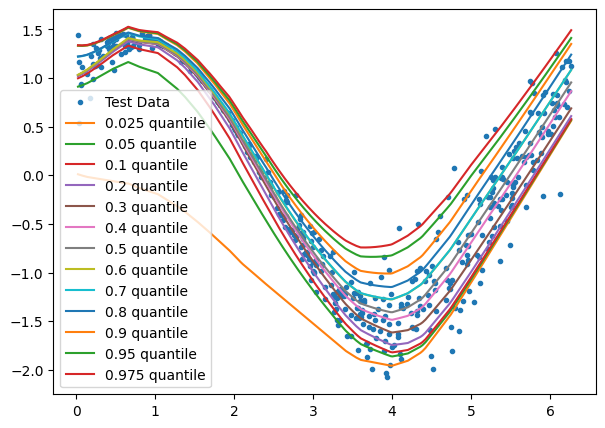

In [52]:
sort_indices=np.argsort(X_test[:,0])
X_test_sort=X_test[sort_indices]
y_test_sort=y_test[sort_indices]
preds = model.predict(X_test_sort)

plt.plot(X_test_sort,y_test_sort,'.')
plt.plot(X_test_sort,preds)

legend=["Test Data"]
quantiles_str=[str(quant)+" quantile" for quant in quantiles]
legend.extend(quantiles_str)
plt.legend(legend)
plt.show()

In [57]:
X_test_sort

array([[0.02230646],
       [0.03275547],
       [0.03288585],
       [0.06226355],
       [0.0627779 ],
       [0.07759254],
       [0.14023602],
       [0.17137335],
       [0.1831635 ],
       [0.2065227 ],
       [0.21046716],
       [0.21053689],
       [0.22632477],
       [0.24012318],
       [0.25046984],
       [0.25047597],
       [0.26522778],
       [0.28078343],
       [0.29162993],
       [0.29748036],
       [0.3077114 ],
       [0.31673084],
       [0.33743661],
       [0.3893647 ],
       [0.39486226],
       [0.3989602 ],
       [0.40768736],
       [0.41269972],
       [0.41475727],
       [0.41588268],
       [0.4183223 ],
       [0.42871377],
       [0.45257889],
       [0.46079134],
       [0.46363087],
       [0.46509373],
       [0.48057681],
       [0.50333031],
       [0.50544722],
       [0.50852184],
       [0.51016214],
       [0.522771  ],
       [0.54731972],
       [0.56707185],
       [0.59179277],
       [0.59296763],
       [0.61204798],
       [0.615

In [66]:
X_test_sort[0,:]

array([0.02230646])

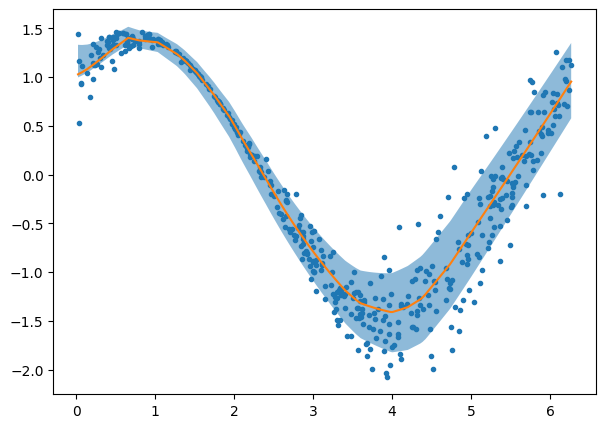

In [72]:
sort_indices=np.argsort(X_test[:,0])
X_test_sort=X_test[sort_indices]
y_test_sort=y_test[sort_indices]
preds = model.predict(X_test_sort)

index_median=6

plt.plot(X_test_sort,y_test_sort,'.')
plt.plot(X_test_sort,preds[:,index_median],'tab:orange')
plt.fill_between(X_test_sort[:,0], preds[:,2], preds[:,10], alpha=0.5)
plt.show()

In [12]:
QuantileNetwork.quant_rate(y_test_sort,preds)

array([0.027 , 0.0442, 0.0896, 0.1946, 0.285 , 0.391 , 0.4944, 0.6094,
       0.7082, 0.8122, 0.9128, 0.96  , 0.9818])

In [13]:
def cdf(pred, x, quantiles):
    r"""
    Approximate the posterior CDF for given inputs x.

    Propagates the inputs in x forward through the network and
    approximates the posterior CDF by a piecewise linear function.

    The piecewise linear function is given by its values at approximate
    quantiles :math:`x_\tau`` for :math:`\tau = \{0.0, \tau_1, \ldots,
    \tau_k, 1.0\}` where :math:`\tau_k` are the quantiles to be estimated
    by the network. The values for :math:`x_{0.0}` and :math:`x_{1.0}` are
    computed using

    .. math::

        x_{0.0} = 2.0 x_{\tau_1} - x_{\tau_2}

        x_{1.0} = 2.0 x_{\tau_k} - x_{\tau_{k-1}}

    Arguments:

        x(np.array): Array of shape (n, m) containing n inputs for which
                        to predict the conditional quantiles.

    Returns:

        Tuple (xs, fs) containing the :math:`x`-values in xs and corresponding
        values of the posterior CDF :math:`F(x)` in fs.

    """
    if len(x.shape) > 1:
        s = x.shape[:-1] + (len(quantiles) + 2,)
    else:
        s = (1, len(quantiles) + 2)

    y_pred = np.zeros(s)
    y_pred[:, 1:-1] = pred
    y_pred[:, 0] = 2.0 * y_pred[:, 1] - y_pred[:, 2]
    y_pred[:, -1] = 2.0 * y_pred[:, -2] - y_pred[:, -3]

    qs = np.zeros(len(quantiles) + 2)
    qs[1:-1] = quantiles
    qs[0] = 0.0
    qs[-1] = 1.0

    return y_pred, qs

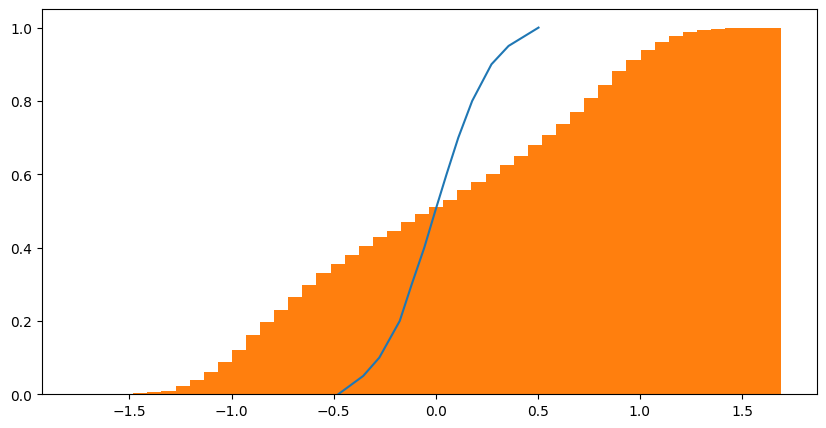

In [14]:
x_cdf, y_cdf = cdf(preds,X_test_sort,quantiles)

plt.plot(np.mean(x_cdf,axis=0),y_cdf)
plt.hist(y_test,cumulative=True, density=True,bins=50)
plt.show()

In [15]:
index_median=6
example_cdf_ix=1
b=4

In [16]:
m=np.abs(preds[:,index_median]-y_test[:])
m_isort=np.argsort(m)
pred_y_post_s=preds[m_isort,:]
y_post_s=y_test[m_isort]
X_post_s=X_test[m_isort]

In [17]:
example_cdf=pred_y_post_s[example_cdf_ix,:]
example_cdf_01=np.zeros(len(quantiles_01))
example_cdf_01[1:-1]=example_cdf
example_cdf_01[-1]=2.0 * example_cdf[-1] -example_cdf[-2]
example_cdf_01[0]= 2.0 * example_cdf[0] -example_cdf[1]
    

example_pdf=(quantiles_01[1:]-quantiles_01[:-1])/(example_cdf_01[1:]-example_cdf_01[:-1])
example_pdf_x=(example_cdf_01[1:]+example_cdf_01[:-1])/2
example_pdf_x_extra=np.zeros(len(example_pdf_x)+2)

example_pdf_x_extra[1:-1]=example_pdf_x
example_pdf_x_extra[0]=example_pdf_x[0]
example_pdf_x_extra[-1]=example_pdf_x[-1]

example_pdf_extra=np.zeros(len(example_pdf)+2)
example_pdf_extra[1:-1]=example_pdf
example_pdf_extra[0]=0
example_pdf_extra[-1]=0

(-0.9838136315345765, 0.007712471485137942)

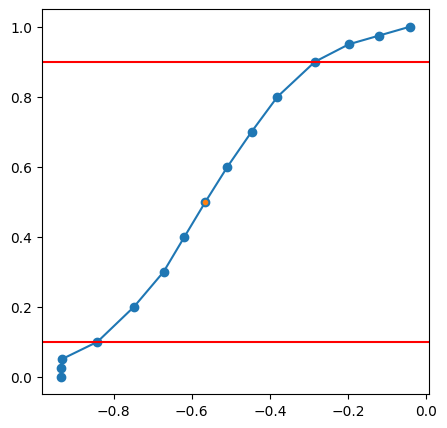

In [18]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(example_cdf_01,quantiles_01,'-o')
plt.plot(y_post_s[example_cdf_ix],0.5,'.')
plt.hlines(0.1,xmin=-1,xmax=1,colors='r')
plt.hlines(0.9,xmin=-1,xmax=1,colors='r')
plt.xlim(np.min(example_cdf_01)-0.05,np.max(example_cdf_01)+0.05)

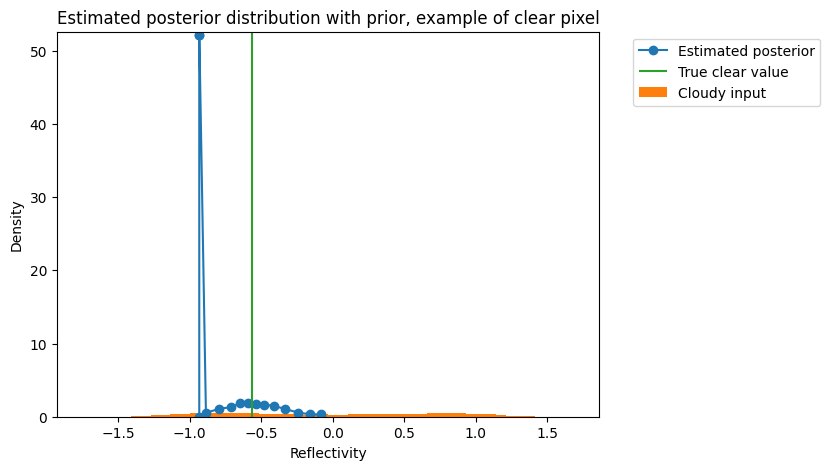

In [19]:
plt.rcParams["figure.figsize"] = [7, 5]
plt.plot(example_pdf_x_extra,example_pdf_extra,'-o')
plt.hist(y_test,density=True,bins=50)
plt.vlines(y_post_s[example_cdf_ix],ymin=0,ymax=np.max(example_pdf)+10,colors='tab:green')
#plt.vlines(X_post_s[example_cdf_ix],ymin=0,ymax=np.max(example_pdf)+10,colors='tab:pink')
plt.ylim([0,np.max(example_pdf)+0.5])
plt.legend(['Estimated posterior','True clear value','Cloudy input','Prior distribution'],bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Estimated posterior distribution with prior, example of clear pixel')
plt.ylabel('Density')
plt.xlabel('Reflectivity')
plt.show()

## Example Quantiles

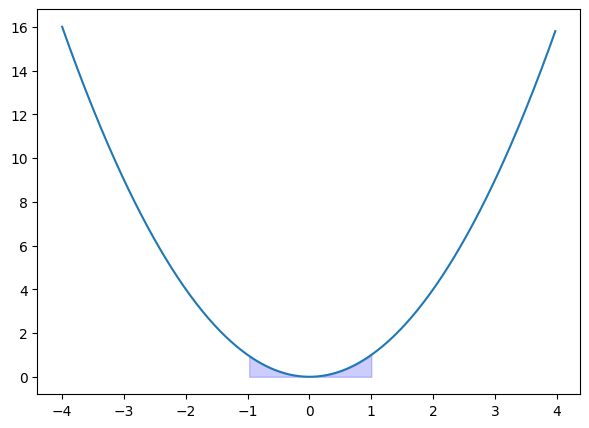

In [20]:
import numpy as np
from matplotlib import pyplot as plt

def f(t):
    return t * t

t = np.arange(-4,4,1/40)

#Print the curve
plt.plot(t,f(t))

#Fill under the curve
plt.fill_between(
        x= t, 
        y1= f(t), 
        where= (-1 < t)&(t < 1),
        color= "b",
        alpha= 0.2)
        
plt.show()

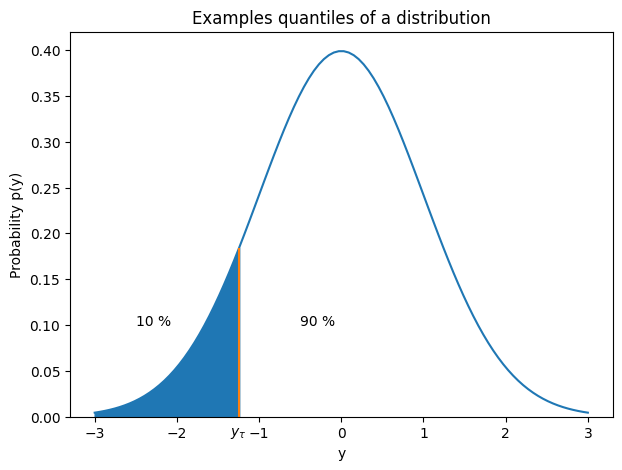

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf=stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf)
plt.vlines(x[29],ymin=-1,ymax=pdf[29],colors='tab:orange')
plt.fill_between(
        x= x, 
        y1= pdf, 
        where= (x[29] >= x)&(x >= -3),
        color= "tab:blue",
        alpha= 1)
plt.ylim([0,0.42])
plt.title('Examples quantiles of a distribution')
plt.annotate(r'10 %',xy=[-2.5,0.10])
plt.annotate(r'90 %',xy=[-0.5,0.10])
plt.ylabel('Probability p(y)')
plt.xlabel('y')
plt.text(-1.35,-0.02,r'$y_\tau$')
plt.show()

In [22]:
x[50]

0.030303030303030276

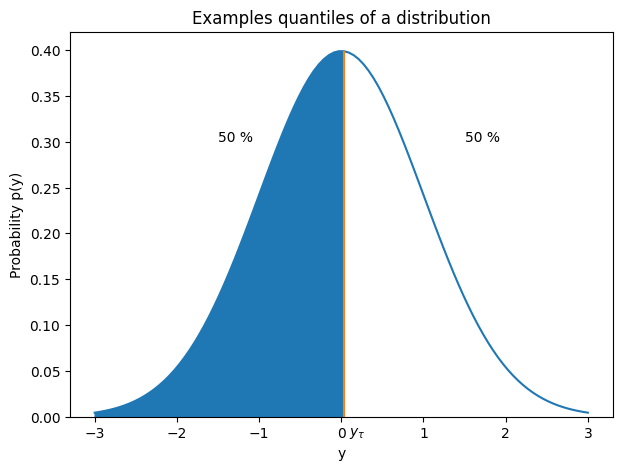

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf=stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf)
plt.vlines(x[50],ymin=-1,ymax=pdf[50],colors='tab:orange')
plt.fill_between(
        x= x, 
        y1= pdf, 
        where= (x[50] >= x)&(x >= -3),
        color= "tab:blue",
        alpha= 1)
plt.ylim([0,0.42])
plt.title('Examples quantiles of a distribution')
plt.annotate(r'50 %',xy=[-1.5,0.30])
plt.annotate(r'50 %',xy=[1.5,0.30])
plt.ylabel('Probability p(y)')
plt.xlabel('y')
plt.text(0.1,-0.02,r'$y_\tau$')
plt.show()

In [24]:
(x[29] < x)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [25]:
x[29]

-1.2424242424242424

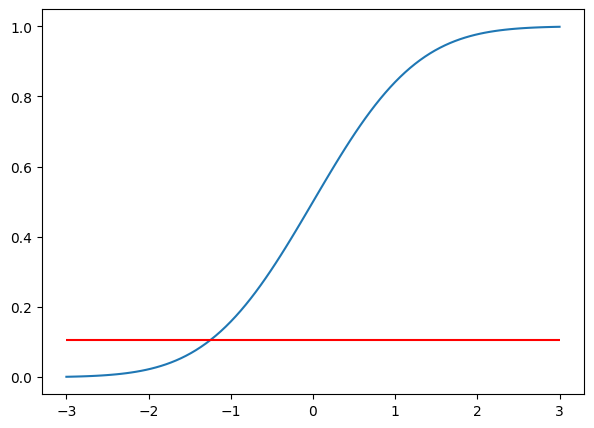

In [26]:
cdf=stats.norm.cdf(x, mu, sigma)
plt.plot(x, cdf)
plt.hlines(cdf[29],xmin=-3,xmax=3,colors='r')
plt.show()

In [27]:
cdf[29]

0.10704003789347644

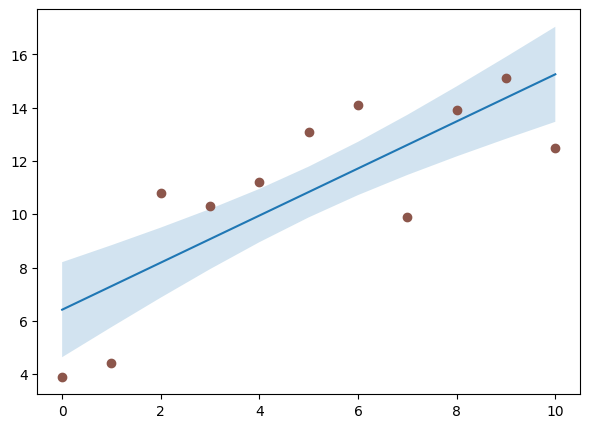

In [28]:
N = 21
x = np.linspace(0, 10, 11)
y = [3.9, 4.4, 10.8, 10.3, 11.2, 13.1, 14.1,  9.9, 13.9, 15.1, 12.5]

# fit a linear curve and estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) +
                          (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig, ax = plt.subplots()
ax.plot(x, y_est, '-')
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
ax.plot(x, y, 'o', color='tab:brown')